# Friends. Topic Modeling

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from collections import defaultdict, Counter
from nltk.stem import WordNetLemmatizer
from string import punctuation, digits
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.util import ngrams
import pandas as pd
import requests
import gensim
import re

  
lemmatizer = WordNetLemmatizer() 
punct = punctuation+'«»—…“”*№–'+digits
stops = set(stopwords.words('english'))

In [2]:
def word_check(sent):
    words = []
    for index, word in enumerate(word_tokenize(sent.lower())):
        word = word.strip(punct)
        word = lemmatizer.lemmatize(word)
        if word.isalpha() and word not in stops and len(word) > 2: 
            words.append(word)
    return words

def normalize(text, word_check):
    words = []
    text = re.sub(' ', ' ', text)
    text = re.sub('\(.+?\)', '', text)
    text = re.sub('^(.+?): ', '', text)
    
    for sent in sent_tokenize(text):
        sent = word_check(sent)
        words += sent
    return words

def parse_episode(soup, cast_lines, cast, normalize, word_check):
    episode = []
    
    for index, line in enumerate(soup.find_all('p')):

        if index > 0:
            
            person = line.find_all('b')
            if not person: person = line.find_all('strong')
            lines = normalize(line.text, word_check)
            
            if person:
                person = normalize(person[0].text, word_check)
                if person and person[0] in cast:
                    cast_lines[person[0]][-1] += 1
                    
            episode += lines
    return episode, cast_lines

In [4]:
with open('interjections.txt', 'r', encoding = 'utf-8') as f:
    interjections = f.read()
    interjections = interjections.split('\n')

stops |= set(interjections)

# Скачиваем данные

In [7]:
import os

In [ ]:
parent_dir = 'friends/'
main_url = 'https://fangj.github.io/friends/'
main = get_soup(main_url)

In [25]:
for link in main.find_all('a'):
    ep, name = link.text.split(' ', 1)
    
    if len(ep) == 4: season = ep[:2]
    else: season = ep[0]

    path = os.path.join(parent_dir, season) 
    if not os.path.isdir(path):
        os.mkdir(path) 
    
    url = main_url + link.attrs['href']
    req = requests.get(url)
    
    if req.status_code == 200:
        html = req.text
        with open(path + '/{}.html'.format(ep), 'w') as f:
            f.write(html)
 

# Открываем данные 

In [10]:
parent_dir = '/friends'

In [11]:
cast = ['joey', 'rachel', 'monica', 'ross', 'chandler', 'phoebe']
season_episode = defaultdict(list)
cast_lines = defaultdict(list)

In [12]:
for directory in os.listdir(os.chdir(parent_dir)):
    if directory != '.DS_Store':
        path = os.path.join(parent_dir, directory) 
        for file in os.listdir(os.chdir(path)):
            with open(file, 'r') as f:
                html = f.read()
                soup = BeautifulSoup(html, 'lxml')
                for per in cast: cast_lines[per].append(0)
                episode, cast_lines = parse_episode(soup, cast_lines, cast, normalize, word_check)
                season_episode[directory].append(episode)

# Описание данных

Я решила взять сценарии сериала Друзья. Сериал состоит из 10 сезонов. Распределение кол-ва серий по сезонам после препроцессинга: 

In [32]:
n_ep, n_w = 0, 0

for i in range(1, 11):
    ssn = str(i)
    n_word = 0
    episodes = season_episode[ssn]
    for ep in episodes: n_word += len(ep)
    n_ep += len(episodes)
    n_w += n_word
    print('Season {}   Num. of ep {}   N words {}'.format(i, len(episodes), n_word))
    
print()
print('Seasons 10   Num. of ep {}   N words {}'.format(n_ep, n_w))

Season 1   Num. of ep 25   N words 29865
Season 2   Num. of ep 23   N words 34983
Season 3   Num. of ep 25   N words 32506
Season 4   Num. of ep 23   N words 21648
Season 5   Num. of ep 23   N words 19799
Season 6   Num. of ep 23   N words 19807
Season 7   Num. of ep 24   N words 19912
Season 8   Num. of ep 23   N words 18438
Season 9   Num. of ep 23   N words 18474
Season 10   Num. of ep 16   N words 11532

Seasons 10   Num. of ep 228   N words 226964


Корпус небольшой. Каждый отдельный текст сам по себе тоже не очень большой, поэтому корпус может быть очень праблематичным для задачи тематического моделирования, но все равно интересно посмотреть на результаты. Будут ли это топики по сзонам? или топики для персонажей?

# LDA

In [33]:
def merge_seasons(season_episode):

    all_ = []
    index_name = []

    for season in season_episode:
        for index, ep in enumerate(season_episode[season]):
#             bigrams = list(ngrams(ep, 2))
#             count = Counter(bigrams)
#             top = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:100]
#             top = ['_'.join(i[0]) for i in top]
#             all_.append(ep + top)
            all_.append(ep)
            index_name.append(season + '_' + str(index))
    return all_, index_name

def make_dictionary(all_):
    dictionary = gensim.corpora.Dictionary(all_)
    dictionary.filter_extremes(no_above=0.3)
    dictionary.compactify()
    corpus = [dictionary.doc2bow(doc) for doc in all_]
    return dictionary, corpus

In [22]:
all_, index_name = merge_seasons(season_episode)
dictionary, corpus = make_dictionary(all_)

## 10 топиков

In [38]:
def words(lda, num_words=10):
    d = {}
    for index, line in enumerate(lda.print_topics(num_words=num_words)):
        d[index] = re.findall('"(.*?)"', line[1])
    return pd.DataFrame(d)

In [24]:
lda_10 = gensim.models.LdaModel(corpus, id2word=dictionary, 
                                 passes=15, num_topics=10,
                                 eta='auto', random_state=42)
words(lda_10, num_words=10)

,0,1,2,3,4,5,6,7,8,9
0,mark,mike,lauren,marcel,carol,richard,cat,emily,car,emma
1,dance,paul,ralph,monkey,julie,dog,smelly,wedding,birthday,win
2,box,ben,bobby,erica,janice,ben,amy,pant,coat,ball
3,naked,wedding,green,chick,susan,carol,school,london,cigarette,wedding
4,audition,christmas,bob,class,restaurant,frank,sandwich,picture,alone,birthday
5,stripper,smoke,fire,grandmother,david,doctor,emma,joke,parent,parent
6,bag,dress,restaurant,key,mike,susan,chip,bing,glass,ben
7,roommate,thanksgiving,interview,van,doctor,wedding,cry,cat,ben,ticket
8,tree,tulsa,lunch,zoo,wine,pete,jill,floor,smoking,car
9,joe,parent,cast,mindy,ben,card,mother,fire,boat,dress


1 тема напоминает 9 сезон
* Фиби знакомится с Майком
* Чендлер переезжает в Талсу, с этим связано и курение (переехав туда он начинает курить)
* Чендлер пропускает День благодарение и Рождество (есть целая серия Christmas in Tulsa)

2 тема может быть связана с Рейчел
* Ральф Лорен - место, где она работала
* Грин - фамилия
* У нее было интервью на новую работу за ланчем в ресторане, из-за которого ее и уволили из  Ральф Лорен

Как связан Бобби я не знаю, это был парень Моники

7 тема напоминает 4 сезон, где Росс женится на Эмили в Лондоне

Остальные тоже можно приплести к героям, но уже хуже

## 5 топиков

In [26]:
lda_5 = gensim.models.LdaModel(corpus, id2word=dictionary, 
                                 passes=15, num_topics=5,
                                 eta='auto', random_state=42)
words(lda_5, num_words=10)

,0,1,2,3,4
0,emily,mike,emma,marcel,richard
1,wedding,wedding,dog,monkey,carol
2,box,paul,birthday,erica,ben
3,mark,ball,bos,christmas,susan
4,london,joke,cake,ben,julie
5,naked,cat,restaurant,card,janice
6,dance,smoke,fire,green,car
7,book,cup,amy,thanksgiving,doctor
8,kathy,relationship,picture,class,parent
9,cat,thanksgiving,bing,chick,mike


Тут уже хуже дела обстоят

## 15 топиков

In [27]:
lda_15 = gensim.models.LdaModel(corpus, id2word=dictionary, 
                                 passes=15, num_topics=15,
                                 eta='auto', random_state=42)
words(lda_15, num_words=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,naked,paul,ralph,erica,carol,richard,cat,emily,birthday,emma,car,message,marcel,julie,christmas
1,mark,wedding,lauren,chick,susan,doctor,emma,london,coat,ball,dog,richard,cat,interview,thanksgiving
2,stripper,ben,wedding,monkey,janice,mike,amy,joke,boat,bob,smoke,barry,monkey,chan,present
3,kathy,dress,paper,grandmother,ben,wedding,cry,wedding,glass,ben,restaurant,mindy,smelly,cat,box
4,roommate,cup,amy,van,restaurant,ben,tulsa,pant,car,birthday,cigarette,chip,hat,pant,wedding


* 6 топик напоминате 9 сезон серию, где приезжает сестра Рейчел Эми, они разбивают тарелки Моники (она плачет из-за этого), Чендлер перезжает в Талсу.

* 7 топик - свадьба Росса и Эмили в Лондоне

* 11 топик - Ричард и Моника расстаются на свадьбе Барри и Минди

#  Удаление имен из текстов

В топиках очень много имен, удалим их

In [34]:
def word_check2(sent):
    words = []
    for index, word in enumerate(word_tokenize(sent)):
        if word.istitle() and index != 0: continue
        else:
            word = word.strip(punct)
            word = lemmatizer.lemmatize(word.lower())
            if word.isalpha() and word not in stops and len(word) > 2:
                words.append(word.lower())
    return words

In [35]:
season_episode2 = defaultdict(list)
cast_lines2 = defaultdict(list)

for directory in os.listdir(os.chdir(parent_dir)):
    if directory != '.DS_Store':
        path = os.path.join(parent_dir, directory) 
        for file in os.listdir(os.chdir(path)):
            with open(file, 'r') as f:
                html = f.read()
                soup = BeautifulSoup(html, 'lxml')
                for per in cast: cast_lines2[per].append(0)
                episode, cast_lines2 = parse_episode(soup, cast_lines2, cast, normalize, word_check2)
                season_episode2[directory].append(episode)

In [36]:
all_2, index_name2 = merge_seasons(season_episode2)
dictionary2, corpus2 = make_dictionary(all_2)

In [31]:
lda2_10 = gensim.models.LdaModel(corpus2, id2word=dictionary2, 
                                 passes=15, num_topics=10,
                                 eta='auto', random_state=42)
words(lda2_10, num_words=10)

,0,1,2,3,4,5,6,7,8,9
0,cat,geller,birthday,rach,roommate,ball,joke,wedding,wedding,monkey
1,cry,bag,book,dog,doctor,richard,hat,picture,richard,marcel
2,ticket,birthday,richard,car,fridge,chick,parent,pant,dad,dad
3,win,dad,parent,dad,flirting,dance,dog,dress,bike,father
4,boyfriend,richard,class,key,guest,set,pant,ticket,candy,light
5,smelly,director,wedding,parent,plate,win,milk,rule,carol,present
6,buy,audition,sandwich,moving,soon,four,counter,laundry,box,shoe
7,tape,book,fish,box,hurt,camera,dad,plan,joke,doctor
8,book,purse,wear,shoe,box,laugh,lunch,machine,toast,grandmother
9,butt,robot,stripper,window,dress,floor,cat,bath,card,glass


Тема 0 может быть связана с Фиби (ее песня smelly cat)

Тема 1 очень подходит под описание 6 сезона:
    * Джо получает роль в сериале про робота
    * Чендлер делает предложение Монике, но в это вмешивается Ричард
    * Росс встречает отца своей девушки

Тема 4 тоже под 6 подходит: 
    * Чендлер живет с Моникой, 
    * Джо находит новую сожителицу, с которой он флиртует

Тема 8 очень хорошо подходит под 7 сезон:
    * Фиби учится ездить на велосипеде в серии The One with All the Candy
    * В этом сезоне Моника и Чендлер играют свадьбу 

9 тема может относиться к Россу

## Распределение топиков

In [42]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [44]:
topic_doc = defaultdict(list)
season_topic = defaultdict(list)
doc_topic = {}


for index, text in enumerate(corpus2):
    
    season = index_name2[index].split('_')[0]
    
    topic, maximum = 0, 0
    topics = lda2_10.get_document_topics(text)
    
    for i in range(10): 
        topic_doc[i].append(0)
        
    for i in range(10): 
        topic_doc[i].append(0)
    
    if season not in season_topic:
        season_topic[season] = [0]*10 
        
    for top in topics:
        t, score = top
        topic_doc[t][-1] = score
        season_topic[season][t] += score
        
        if score > maximum:
            maximum = score 
            topic = t
            
    doc_topic[index] = topic

In [45]:
topic_season = np.zeros((10,10))

for season in season_topic:
    for index, topic in enumerate(season_topic[season]):
        topic_season[index][int(season)-1] += topic

# Проверяем теории

### LDA на текстах с именами

Изобразим распределение топиков по сезонам

In [46]:
ssns = [str(i + 1) for i in range(10)]
data = pd.DataFrame(topic_season)
data = data.T
data.columns = [str(i) for i in range(10)]
data = data.astype(float)
data['season'] = ssns

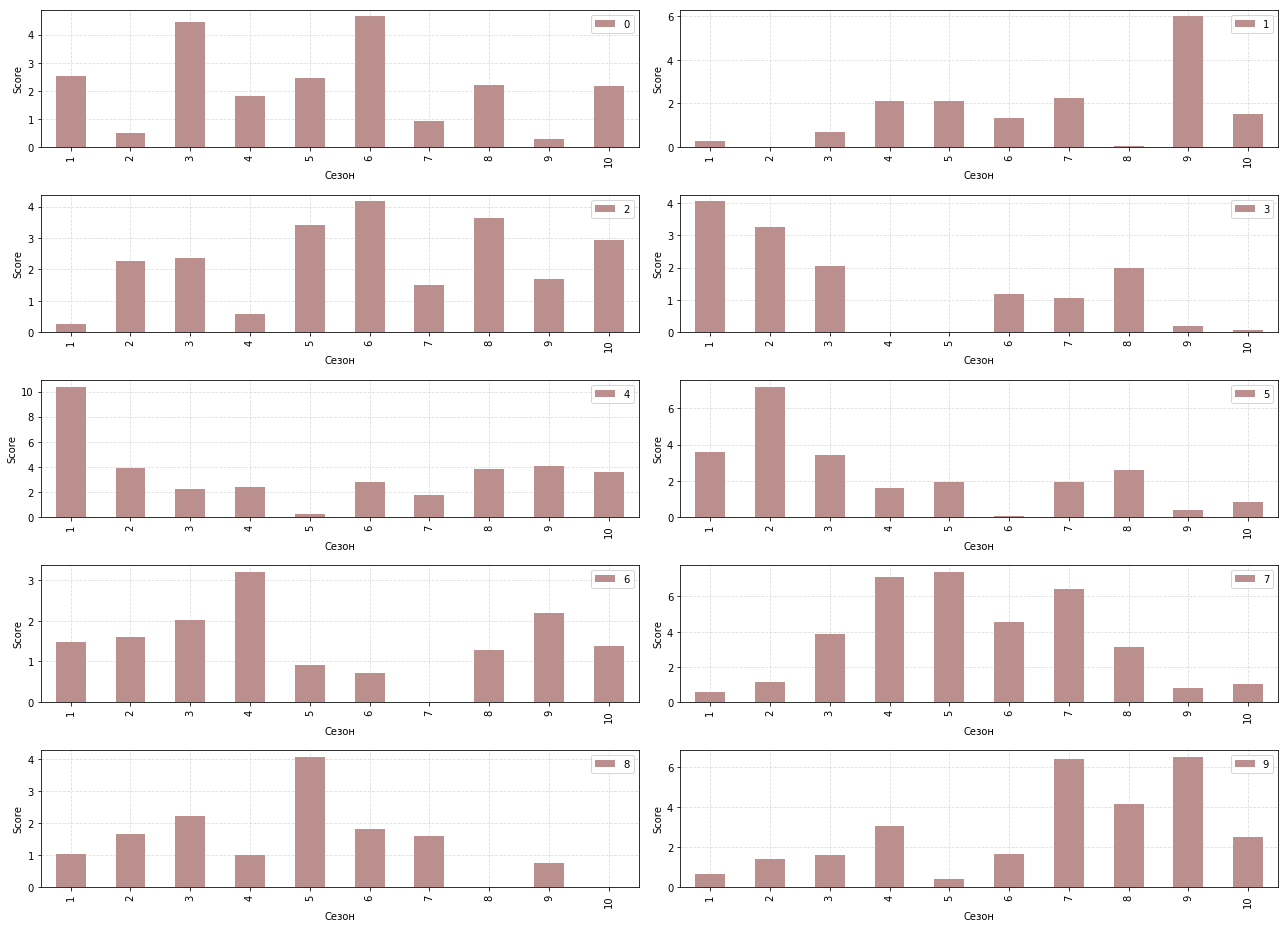

In [134]:
u = ssns
ncols, nrows = 2, 5
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 13))
index = 0

for ax in axes:
    
    for i in range(ncols):
  
        plot = data.plot.bar(x='season', 
                             y=str(i+index), ax=ax[i],
                             color = 'rosybrown')
     
        plot.set_xlabel("Сезон")
        plot.set_ylabel("Score")
        plot.set_axisbelow(True)
        plot.yaxis.grid(color='gainsboro', linestyle='dashed')
        plot.xaxis.grid(color='gainsboro', linestyle='dashed')
    
    index += 2
plt.tight_layout()
plt.show()

* 0 топик - пики находятся в 3 и 6 сезонах, но тема сама по себе очень странная, в ней куски из разных опер, нельзя объединить по какому-то признаку. 
* 1 топик, как я и предполагала тема больше всего релевантра для 9 сезона
* 2 топик предположительно пока может относиться к Рейчел
* 3 топик больше всего характерен для ранних сезонов, это неудивительно, в нем собрались слова, которые четко ассоциируются с ранними сезонами (обезьяна, бабушка, Минди), но все такие тоже сборная солянка. 
* 4 топик больше всего характерен для первого сезона, однако четко сказать, что это первый сезон сложно, так как там есть имена персонажей из более поздних сезонов. 
* 7 топик больше всего релевантен для 4 и 5 сезона (в пятом сезоне продолжает стори лайн с Эмили)
* 8 топик связан с 5 сезоном, но я не могу их связать, слова слишком общие.

В итоге:

* 1 топик действительно больше всего релевантен для 9 сезона
* 7 топик больше всего релевантен для 4 и 5 сезона (в пятом сезоне продолжает стори лайн с Эмили)

Остальные топики, как и предполагалось, не очень информативные. Корпуса маленького объема с большей долей прямой речи не очень подходит для задачи тематического моделирования. 

## 2 тема связана с Рейчел?

Нарисуем частотность речей Рейчел по сезонам и сравним с распределением 2 топика по сезонам

In [139]:
rachel = cast_lines['rachel']
rach_seas = [0]*10
        
for index, episode in enumerate(rachel):
    
    season = index_name2[index].split('_')[0]
    rach_seas[int(season)-1] += episode

In [141]:
data['rachel'] = rach_seas

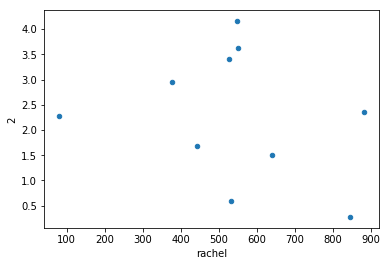

In [148]:
data.plot.scatter(x='rachel', y='2')

Линейной зависимости нет

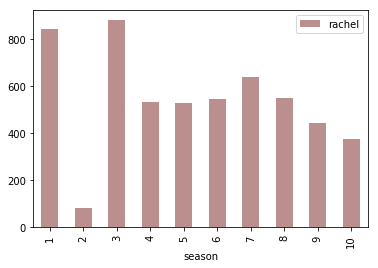

In [151]:
data.plot.bar(x='season', 
              y='rachel',
              color = 'rosybrown')

Пики не совпадают с пиками топика 2. Но, мне кажется, этого все таки недостаточно, чтобы отвергнуть предположение.